In [1]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM

import matplotlib.pyplot as plt

C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-17 15:52:23,030 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
castle.__version__

'1.0.3'

In [3]:
# Mute warnings - for the sake of presentation clarity
# Should be removed for real-life applications
# warnings.simplefilter('ignore')

# Beyond The Basics! Level Up Your Causal Discovery Skills in Python Now (2023)


The recent surge in interest in causality-related topics in Python has led to a wealth of resources, making it challenging to find the ones that are aligned with your learning goals.

As I began my adventure with causality some three years ago, I spent countless hours scouring the internet for valuable resources and robust libraries, determined to find the tools I needed to move on in my causal journey.

This blog is a part of the series where I share practical tips on learning and implementing causal models in Python.

If you're interested in modern causality, I've distilled over three years of hard-won knowledge and experience into an accessible guide that will help you master causality in a fraction of the time it would take to do all the research and coding yourself. 

Check my upcoming [causal book](https://causalpython.io) and be sure to join our growing community at [causalpython.io](https://causalpython.io) for even more tips, tricks, and support. See you there! :) 

Now, let's learn something new!

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=200 align="left"></a>
<br><br><br>


## Blog post

## Installing the environment

* Using **Conda**:

    `conda env create --file causality-causalpython-py38.yml`


* Installing `gcastle` only:

    `pip install gcastle==1.0.3`

In [4]:
def get_n_undirected(g):
    
    total = 0
    
    for i in range(g.shape[0]):
        for j in range(g.shape[0]):
            if (g[i, j] == 1) and (g[i, j] == g[j, i]):
                total += .5
    
    return total

## PC algorithm

**PC algorithm** starts with a **fully connected** graph and then performs a series of steps to remove edges, based on graph independence structure. Finally, it tries to orient as many edges as possible.

Figure 1 presents a visual representatrion of these steps.

<br><br>

<img src="img/glymour_et_al_pc.jpg">

<br>

<figcaption><center><b>Figure 1. </b>Original graph and PC algorithm steps. (Gylmour et al., 2019)</center></figcaption>

<br>


Interested in more details? 
[Gylmour et al. - Review of Causal Discovery Methods Based on Graphical Models (2019)](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full)

In [5]:
# Let's implement this structure
x = np.random.randn(1000)
y = np.random.randn(1000)

z = x + y + .1 * np.random.randn(1000)
w = .7 * z + .1 * np.random.randn(1000)

In [6]:
# To matrix
pc_dataset = np.vstack([x, y, z, w]).T

In [7]:
# Sanity check
pc_dataset, pc_dataset.shape

(array([[-0.011,  0.992,  1.122,  1.038],
        [ 1.571, -1.177,  0.492,  0.565],
        [ 0.334, -0.411, -0.051, -0.097],
        ...,
        [ 0.051, -0.03 , -0.066, -0.199],
        [ 0.633, -0.026,  0.774,  0.501],
        [ 0.179,  0.573,  0.649,  0.402]]),
 (1000, 4))

In [8]:
# Build the model
pc = PC()
pc.learn(pc_dataset)

In [9]:
pc.causal_matrix

Tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

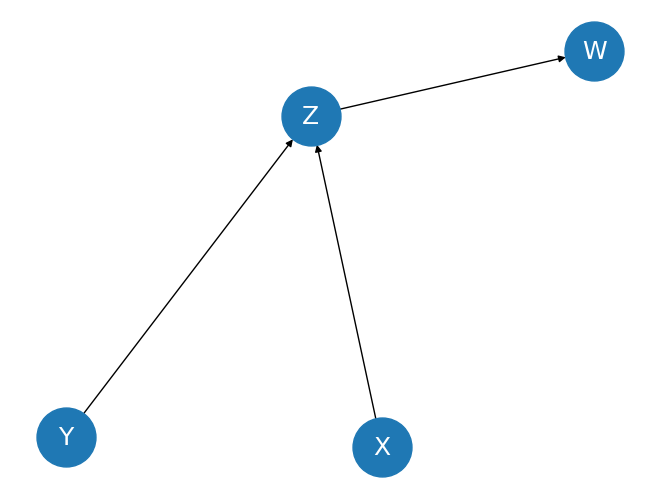

In [10]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['X', 'Y', 'Z', 'W'])}
learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)

# Plot the graph
nx.draw(
    learned_graph, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white'
)

## Let's do some more discovery!

### Generate datasets

We'll use a [scale-free](https://en.wikipedia.org/wiki/Scale-free_network) model to generate graphs.

Then we'll use three different causal models on this graph:

* linear Gaussian
* linear exp
* non-linear quadratic

In [11]:
# Data simulation, simulate true causal dag and train_data.
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=18)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'], 
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:
        
        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag, 
            n=2000, 
            method=linearity, 
            sem_type=distr)


2023-01-17 15:55:24,105 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-01-17 15:55:24,105 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2023-01-17 15:55:24,105 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


In [12]:
# Sanity check
datasets

{'linear_gauss': <castle.datasets.simulator.IIDSimulation at 0x2d5c608eb20>,
 'linear_exp': <castle.datasets.simulator.IIDSimulation at 0x2d5c5bcceb0>,
 'nonlinear_quadratic': <castle.datasets.simulator.IIDSimulation at 0x2d5c608ecd0>}

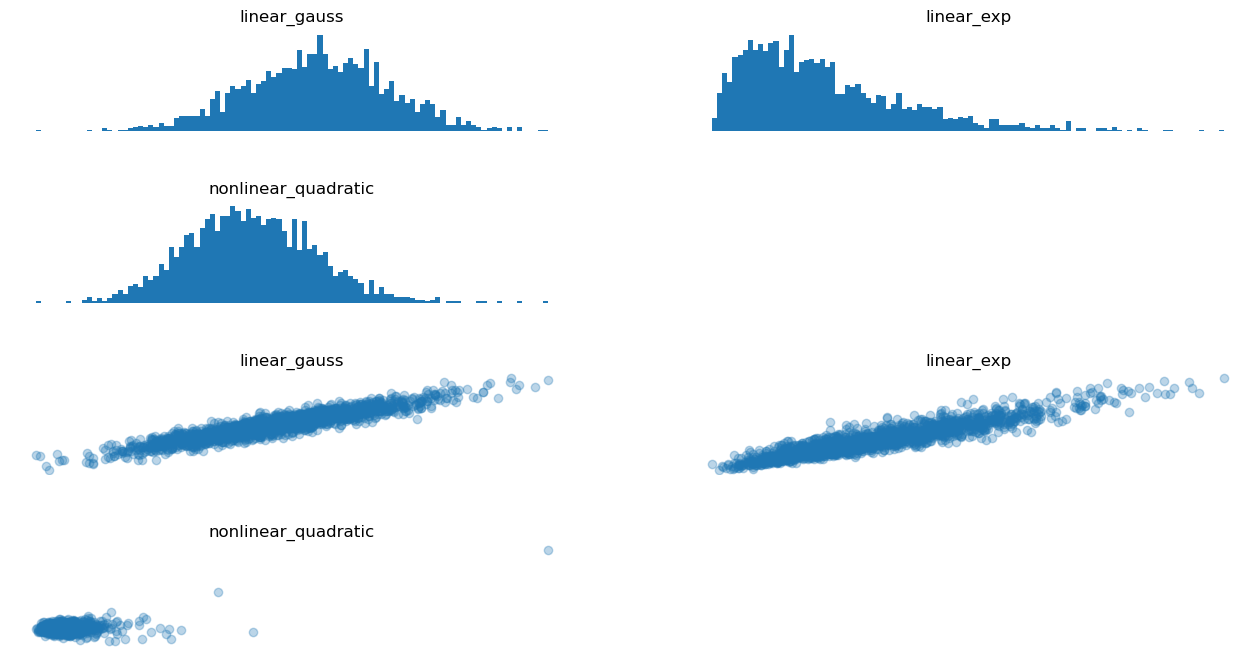

In [13]:
plt.figure(figsize=(16, 8))
for i, dataset in enumerate(datasets):
    X = datasets[dataset].X
    
    plt.subplot(4, 2, i + 1)
    plt.hist(X[:, 0], bins=100)
    plt.title(dataset)
    plt.axis('off')
    
    plt.subplot(4, 2, i + 5)
    plt.scatter(X[:, 8], X[:, 4], alpha=.3)
    plt.title(dataset)
    plt.axis('off')
    
plt.subplots_adjust(hspace=.7)
plt.show()

### Visualize the true graph

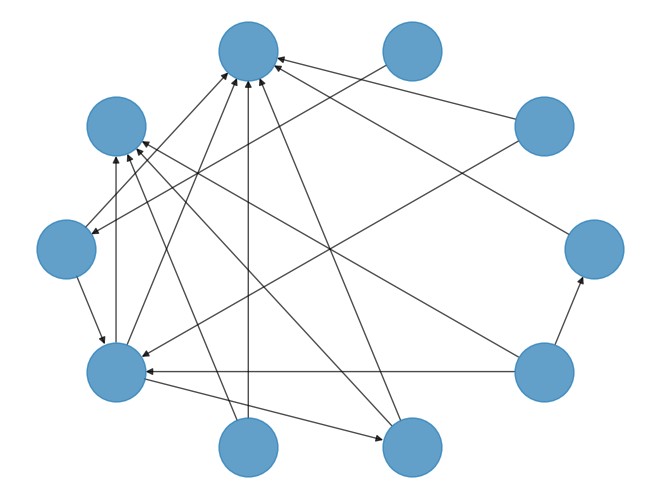

In [14]:
nx.draw(
    nx.DiGraph(true_dag), 
    node_size=1800,
    alpha=.7,
    pos=nx.circular_layout(nx.DiGraph(true_dag))
)

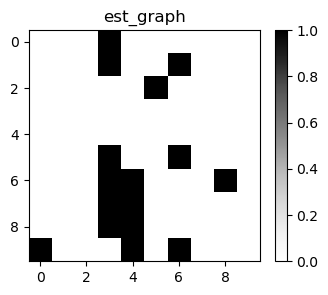

In [15]:
GraphDAG(true_dag)
plt.show()

## Method comparison 

In [16]:
methods = OrderedDict({
    'PC': PC,
    'GES': GES,
    'LiNGAM': ICALiNGAM,
    'GOLEM': GOLEM
})

************* Current dataset: linear_gauss

Method: PC


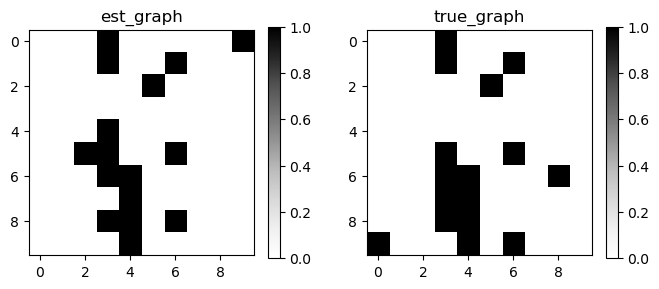

FDR: 0.2
Recall: 0.75
Precision: 0.75
F1 score: 0.75
SHD score: 5
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


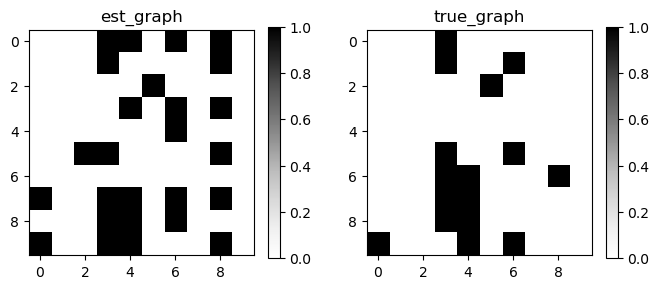

FDR: 0.5833
Recall: 0.625
Precision: 0.3846
F1 score: 0.4762
SHD score: 17
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


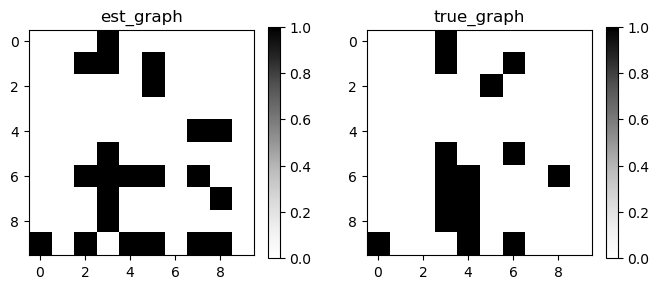

2022-12-11 21:27:24,122 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2022-12-11 21:27:24,164 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2022-12-11 21:27:24,219 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=60.775, likelihood=60.775, h=0.0e+00


FDR: 0.5455
Recall: 0.625
Precision: 0.4545
F1 score: 0.5263
SHD score: 15
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2022-12-11 21:27:33,272 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=49.805, likelihood=49.489, h=1.6e-04
2022-12-11 21:27:41,833 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=49.804, likelihood=49.489, h=1.5e-04
2022-12-11 21:27:49,801 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=49.804, likelihood=49.489, h=1.6e-04
2022-12-11 21:27:57,718 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=49.804, likelihood=49.489, h=1.5e-04
2022-12-11 21:28:05,938 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-pack

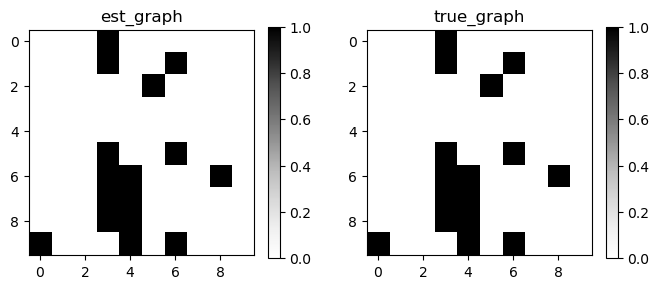

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: linear_exp

Method: PC


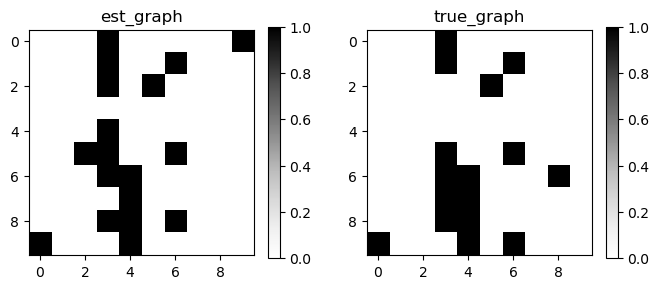

FDR: 0.1875
Recall: 0.8125
Precision: 0.7222
F1 score: 0.7647
SHD score: 5
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: GES


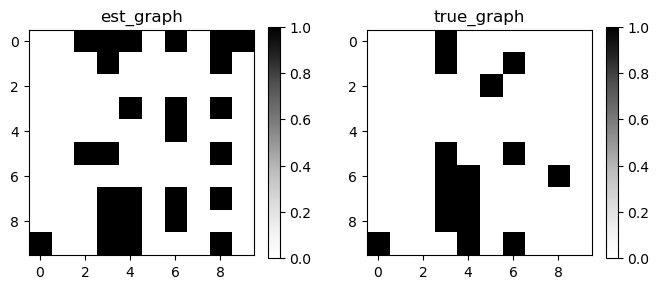

FDR: 0.625
Recall: 0.5625
Precision: 0.3462
F1 score: 0.4286
SHD score: 18
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


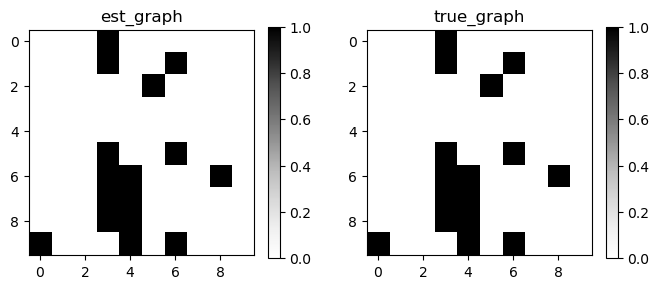

2022-12-11 21:28:09,226 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2022-12-11 21:28:09,231 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2022-12-11 21:28:09,233 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=70.581, likelihood=70.581, h=0.0e+00


FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2022-12-11 21:28:17,640 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=51.017, likelihood=50.664, h=2.2e-03
2022-12-11 21:28:27,751 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=51.013, likelihood=50.660, h=2.1e-03
2022-12-11 21:28:36,928 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=51.013, likelihood=50.660, h=2.2e-03
2022-12-11 21:28:46,582 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=51.013, likelihood=50.660, h=2.2e-03
2022-12-11 21:28:55,243 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-pack

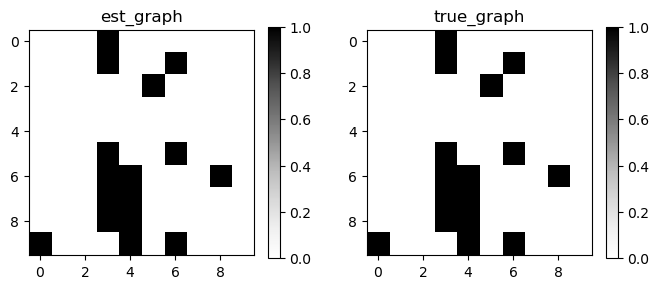

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
SHD score: 0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: nonlinear_quadratic

Method: PC


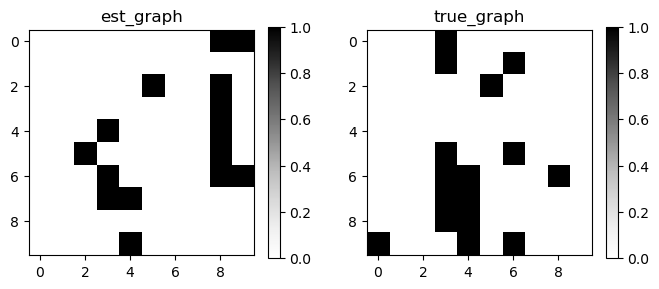

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 14
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


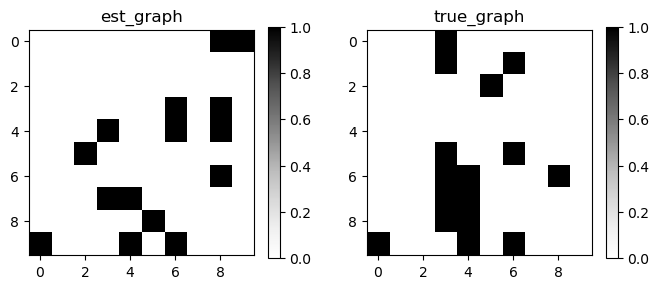

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
SHD score: 13
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: LiNGAM


C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


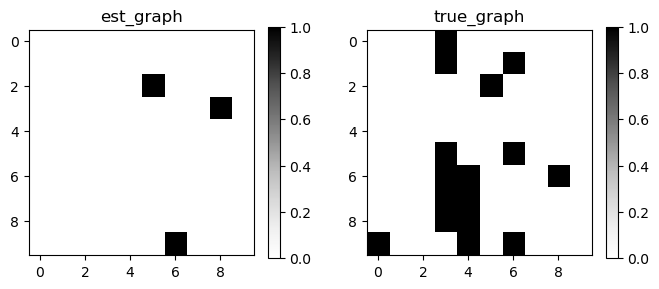

2022-12-11 21:28:57,599 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:120] - INFO: GPU is available.
2022-12-11 21:28:57,605 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:207] - INFO: Started training for 25000 iterations.
2022-12-11 21:28:57,606 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 0] score=55.103, likelihood=55.103, h=0.0e+00


FDR: 0.3333
Recall: 0.125
Precision: 0.6667
F1 score: 0.2105
SHD score: 14
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


2022-12-11 21:29:06,846 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 5000] score=53.118, likelihood=52.721, h=2.1e-02
2022-12-11 21:29:15,468 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 10000] score=53.118, likelihood=52.721, h=2.1e-02
2022-12-11 21:29:24,145 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 15000] score=53.118, likelihood=52.721, h=2.1e-02
2022-12-11 21:29:33,087 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-packages\castle\algorithms\gradient\notears\torch\golem.py[line:220] - INFO: [Iter 20000] score=53.118, likelihood=52.721, h=2.1e-02
2022-12-11 21:29:42,710 - C:\Users\aleks\anaconda3\envs\causality-causalpython-py38\lib\site-pack

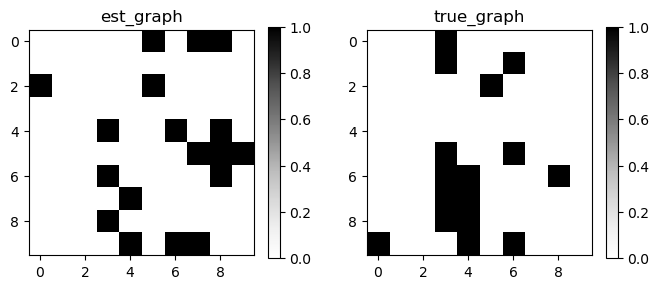

FDR: 0.6111
Recall: 0.4375
Precision: 0.3889
F1 score: 0.4118
SHD score: 18
No. of undir. edges: 0

-------------------------------------------------- 



CPU times: total: 13min 20s
Wall time: 2min 23s


In [21]:
%%time

results = {}

for k, dataset in datasets.items():
    print(f'************* Current dataset: {k}\n')
    X = dataset.X
    
    results[dataset] = {}
    
    for method in methods:

        print(f'Method: {method}')

        # Fit the model
        if method == 'GOLEM':
            model = methods[method](num_iter=2.5e4)
        else:
            model = methods[method]()
        
        # Fit the model
        model.learn(X)
        
        # Get the DAG
        pred_dag = model.causal_matrix
              
        # Get n undir edges
        n_undir = get_n_undirected(pred_dag)

        # Plot results
        GraphDAG(pred_dag, true_dag, 'result')

        mt = MetricsDAG(pred_dag, true_dag)
        print(f'FDR: {mt.metrics["fdr"]}')
        print(f'Recall: {mt.metrics["recall"]}')
        print(f'Precision: {mt.metrics["precision"]}')
        print(f'F1 score: {mt.metrics["F1"]}')
        print(f'SHD score: {mt.metrics["shd"]}')
        print(f'No. of undir. edges: {n_undir}\n')
        print('-' * 50, '\n')

        results[dataset][method] = pred_dag      
            
    print('\n')         